In [1]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from Naive_CNN_1D import *
from output_statistics import *

from torch.utils.tensorboard import SummaryWriter
from torchmetrics.image import StructuralSimilarityIndexMeasure as ssim
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from torchmetrics.image import PeakSignalNoiseRatio 

trancuate_t = 96 # set this parameter to control at which time step you stop using the signal
grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

In [2]:
def reshape_for_pytorch_2(data, grouped_time_steps):
    """
    Reshapes complex-valued MRSI data into a format suitable for PyTorch CNN training.

    Parameters:
    - data: numpy array of shape (x, y, z, grouped_time_steps, N), where:
        * (x, y) are spatial dimensions (image size),
        * 21 is the number of slices along the z-axis, or T alternatively,
        * grouped_time_steps is the number of grouped time steps,
        * N is the number of samples (data points).

    Returns:
    - reshaped_data: PyTorch tensor of shape (N, grouped_time_steps * 2, x, y, z).
    """
    #x, y, z = data.shape[0], data.shape[1], data.shape[2]
    # Separate real and imaginary parts
    N = data.shape[-1]
    real_part = np.real(data)
    imag_part = np.imag(data)

    # Interleave real and imaginary parts along the feature axis

        # Handle the special case for k = 1
    interleaved = np.empty((8, 2, N), dtype=np.float32)
    interleaved[:, 0, :] = real_part  # Real part
    interleaved[:, 1, :] = imag_part  # Imaginary part

    # Transpose to (N, k*2, 22, 22, 21) for PyTorch
    reshaped_data = np.transpose(interleaved, (2, 1, 0))  # Shape: (N, k*2, 22, 22, 21)

    return reshaped_data

def reverse_reshape_for_pytorch_2(reshaped_data, grouped_time_steps=1):
    """
    Reverses the reshaping performed by reshape_for_pytorch_2.
    
    Parameters:
        reshaped_data: numpy array of shape (N, grouped_time_steps*2, x, y, z),
                       where N is the number of samples, 
                       grouped_time_steps is the number of time steps grouped,
                       and (x, y, z) are the spatial dimensions.
        grouped_time_steps: int, the number of grouped time steps.
        
    Returns:
        complex_data: numpy array of shape (x, y, z, grouped_time_steps, N) 
                      with complex values (reconstructed from the interleaved real 
                      and imaginary parts).
    """
    # Get the shape of the input.
    N = reshaped_data.shape[-1]
    
    # First, transpose the data so that the sample dimension becomes the last one.
    # This yields shape: (x, y, z, grouped_time_steps*2, N)
    temp = np.transpose(reshaped_data, (2, 3, 4, 1, 0))
    
    # Now, split the channel dimension (of size grouped_time_steps*2) into two parts:
    # one for real and one for imaginary. The new shape will be:
    # (x, y, z, grouped_time_steps, 2, N)
    temp = temp.reshape(x, y, z, grouped_time_steps, 2, N)
    
    # Extract real and imaginary parts.
    real_part = temp[..., 0, :]  # shape: (x, y, z, grouped_time_steps, N)
    imag_part = temp[..., 1, :]  # shape: (x, y, z, grouped_time_steps, N)
    
    # Reconstruct the complex-valued data.
    complex_data = real_part + 1j * imag_part
    
    return complex_data


In [3]:
#### Undersampling Strategy:#####
Undersampling = "Regular" # Options: Regular or Possoin or Complementary_Masks
Sampling_Mask = "Complementary_Masks" #Options: Single_Combination or One_Mask or Complementary_Masks
AF = 2 #  acceleration factor

#### Model Input and Output ####
GT_Data = "LowRank" # Options: FullRank LowRank for GROUNDTRUTH!
Low_Rank_Input = True ## apply low rank to the input as well if True

####M Model Parameters ####
batch_size=64
num_convs = 10

1. Loading data

In [4]:
#### Define ground truth path####
if GT_Data == "FullRank":
    ground_truth_path = "../data/Ground_Truth/Full_Rank/P03-P08_truncated_k_space.npy"
elif GT_Data == "LowRank":
    ground_truth_path = "../data/Ground_Truth/Low_Rank/LR_8_P03-P08_self.npy"

#### Define Input Data path
undersampled_data_path = "../data/Undersampled_Data/"+Undersampling+f'/AF_{AF}/'+Sampling_Mask+'/data.npy'

#### Definie Model path
if GT_Data == "FullRank":
    saved_model_path = f"../saved_models/Naive_CNN_3D/Full2Full/"+Undersampling+f'/AF_{AF}/'+f'Truncate_t_{trancuate_t}/'+Sampling_Mask+f'/{num_convs}Layer/model.pth'
elif GT_Data == "LowRank":
    saved_model_path = f"../saved_models/Naive_CNN_3D/Low2Low/"+Undersampling+f'/AF_{AF}/'+f'Truncate_t_{trancuate_t}/'+Sampling_Mask+f'/{num_convs}Layer/model.pth'
    
    
#### load data!
Ground_Truth = np.load(ground_truth_path)
Undersampled_Data = np.load(undersampled_data_path)

#### additionally make LowRank 8 transformation on input of network, this improves the error significantly!
if Low_Rank_Input:
    Undersampled_Data[...,0] = low_rank(Undersampled_Data[...,0], 8)
    Undersampled_Data[...,1] = low_rank(Undersampled_Data[...,1], 8)
    Undersampled_Data[...,2] = low_rank(Undersampled_Data[...,2], 8)
    Undersampled_Data[...,3] = low_rank(Undersampled_Data[...,3], 8)
    Undersampled_Data[...,4] = low_rank(Undersampled_Data[...,4], 8)
    Undersampled_Data[...,5] = low_rank(Undersampled_Data[...,5], 8)

2.Train / Test split;  Fourier transform and undersampling, reshaping etc.

In [5]:
#### Train_Test_Split ####
ground_truth_train, ground_truth_test = Ground_Truth[:,:,:,:,:,:5], Ground_Truth[:,:,:,:,:,5]  # Method: Leave last MRSI measurement as test set

#### Assign undersampled network input ####
NN_input_train, NN_input_test = Undersampled_Data[:,:,:,:trancuate_t,:,:5], Undersampled_Data[:,:,:,:trancuate_t,:,5]

#### Reshape T first ####
ground_truth_train, ground_truth_test = ground_truth_train.transpose(4, 0, 1, 2, 3, 5), ground_truth_test.transpose(4, 0, 1, 2, 3)
NN_input_train, NN_input_test = NN_input_train.transpose(4, 0, 1, 2, 3, 5), NN_input_test.transpose(4, 0, 1, 2, 3)


#### Collapse ununsed dimensions ####
ground_truth_train, ground_truth_test = ground_truth_train.reshape(8, -1), ground_truth_test.reshape(8, -1)
NN_input_train, NN_input_test = NN_input_train.reshape(8, -1), NN_input_test.reshape(8, -1)

# #### reshape for pytorch ####
train_data, train_labels  = reshape_for_pytorch_2(NN_input_train, grouped_time_steps), reshape_for_pytorch_2(ground_truth_train, grouped_time_steps)
test_data, test_labels = reshape_for_pytorch_2(NN_input_test, grouped_time_steps), reshape_for_pytorch_2(ground_truth_test, grouped_time_steps)

In [6]:
test_data.shape

(975744, 2, 8)

Load things up...

In [7]:
batch_size=4096

# Create TensorDataset instances
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Next I set up the model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_convs = 3  # Number of convolutional layers
model = Naive_CNN_1D(in_channels=2, num_convs=3, kernel_size=3).to(device)

print(model)

Naive_CNN_1D(
  (conv_layers): Sequential(
    (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): LeakyReLU(negative_slope=0.01)
  )
  (final_conv): Conv1d(64, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  (final_activation): LeakyReLU(negative_slope=0.01)
)


In [9]:
# Training loop
num_epochs = 500
print_every = 1  # Print every epoch

# Initialize model, optimizer, and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.00002)
loss_fn = CustomLoss()

# Move model to device
model = model.to(device)

for epoch in range(num_epochs):
    # Train for one epoch
    _ = train_one_epoch(model, optimizer, loss_fn, train_loader, device=device)

    # Evaluate on training set (MSE only)
    avg_loss_train = validate_model(model, loss_fn, train_loader, device=device)
    
    # Evaluate on test set (MSE only)
    avg_loss_test = validate_model(model, loss_fn, test_loader, device=device)
    
    if (epoch + 1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"   Train Loss (MSE): {avg_loss_train:.6f}")
        print(f"   Test  Loss (MSE): {avg_loss_test:.6f}\n")

# Optionally, plot the learning curves (if you are storing the losses in lists)
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, num_epochs + 1), train_mses, label="Training Loss (MSE)")
# plt.plot(range(1, num_epochs + 1), test_mses, label="Test Loss (MSE)")
# plt.title("Learning Curve")
# plt.xlabel("Epoch")
# plt.ylabel("Loss (MSE)")
# plt.legend()
# plt.grid()
# plt.show()


Epoch 1/500
   Train Loss (MSE): 774170.238489
   Test  Loss (MSE): 773858.777819

Epoch 2/500
   Train Loss (MSE): 760852.026197
   Test  Loss (MSE): 760010.592168

Epoch 3/500
   Train Loss (MSE): 757503.425844
   Test  Loss (MSE): 756104.978769

Epoch 4/500
   Train Loss (MSE): 755729.929887
   Test  Loss (MSE): 753879.866908

Epoch 5/500
   Train Loss (MSE): 754390.983479
   Test  Loss (MSE): 752639.153044

Epoch 6/500
   Train Loss (MSE): 753448.392537
   Test  Loss (MSE): 751668.789072

Epoch 7/500
   Train Loss (MSE): 752719.661815
   Test  Loss (MSE): 750897.584571

Epoch 8/500
   Train Loss (MSE): 752102.731284
   Test  Loss (MSE): 750540.551948

Epoch 9/500
   Train Loss (MSE): 751697.762734
   Test  Loss (MSE): 750433.990698

Epoch 10/500
   Train Loss (MSE): 751174.264046
   Test  Loss (MSE): 749661.294897



KeyboardInterrupt: 

In [10]:
model.eval()

# Initialize lists to store outputs and labels
outputs_list = []
inputs_img_list = []
input_kspace_list = []
labels_list = []

    # Disable gradient computation for efficiency
with torch.no_grad():
    for data, labels in test_loader:
            # Unpack the tuple returned by the dataset
        inputs_img = data

            # Move the tensors to the appropriate device
        inputs_img = inputs_img.to(device)
        labels = labels.to(device)

            # Pass the inputs as a tuple to the model
        outputs = model((inputs_img))

            # If outputs is a tuple, extract the first element
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        # Append outputs and labels to the lists
        outputs_list.append(outputs.cpu().numpy())  # Convert to numpy and move to CPU
        labels_list.append(labels.cpu().numpy())   # Convert to numpy and move to CPU
        inputs_img_list.append(inputs_img.cpu().numpy())
        
#     # Convert to final arrays
outputs = np.concatenate(outputs_list, axis=0)
inputs = np.concatenate(inputs_img_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

outputs_real = outputs[:,0,:]
outputs_img = outputs[:,1,:]
outputs_complex = outputs_real+1j*outputs_img

inputs_real = inputs[:,0,:]
inputs_img = inputs[:,1,:]
inputs_complex = inputs_real+1j*inputs_img

labels_real = labels[:,0,:]
labels_img = labels[:,1,:]
labels_complex = labels_real+1j*labels_img

Outputs = outputs_complex.transpose(1,0)
Inputs = inputs_complex.transpose(1,0)
Labels = labels_complex.transpose(1,0)

prediction = Outputs.reshape(8,22,22,21,96).transpose(1,2,3,4,0)
inputs = Inputs.reshape(8,22,22,21,96).transpose(1,2,3,4,0)
ground_truth = Labels.reshape(8,22,22,21,96).transpose(1,2,3,4,0)

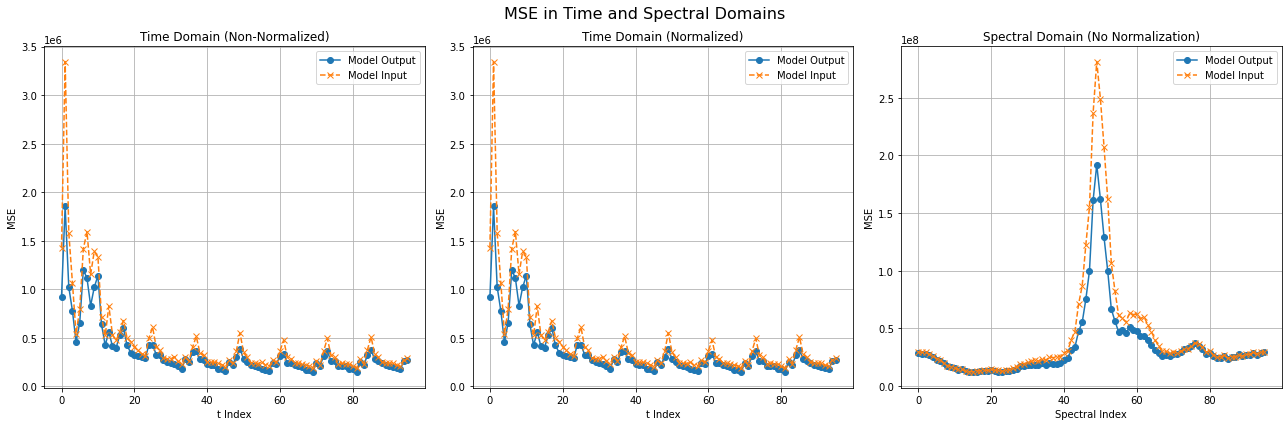

==== Model Output vs Ground Truth ====
Total MSE in image domain: 177723.375
Normalized Total MSE in image domain: 177723.36298433176
Total MSE in spectral domain: 17061442.84649585

==== Model Input vs Ground Truth ====
Total MSE in image domain: 226101.10416666666
Normalized Total MSE in image domain: 226101.0967210116
Total MSE in spectral domain: 21705705.285217095


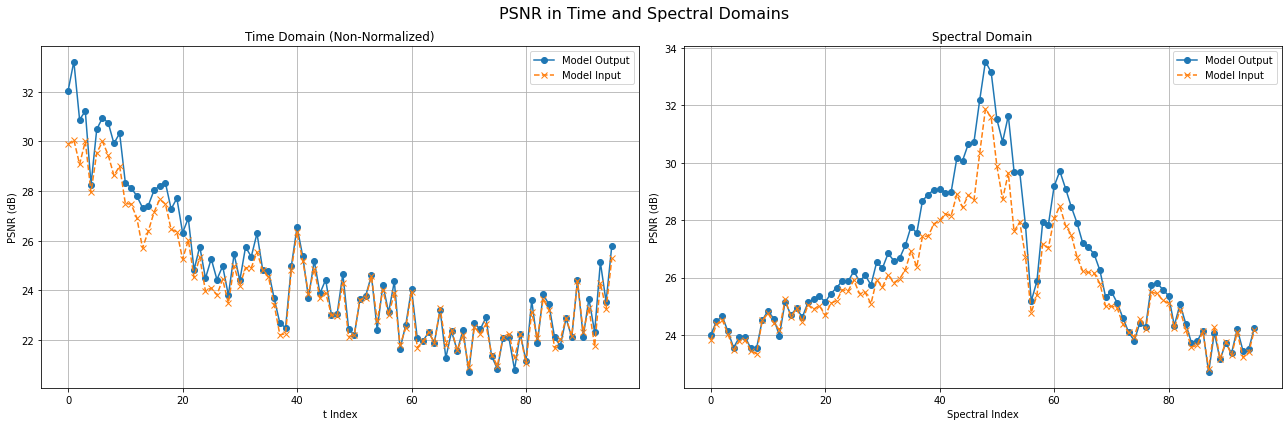

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    24.6806583404541
Average PSNR in frequency domain: 26.32538397760384

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    24.269338607788086
Average PSNR in frequency domain: 25.74449233085279


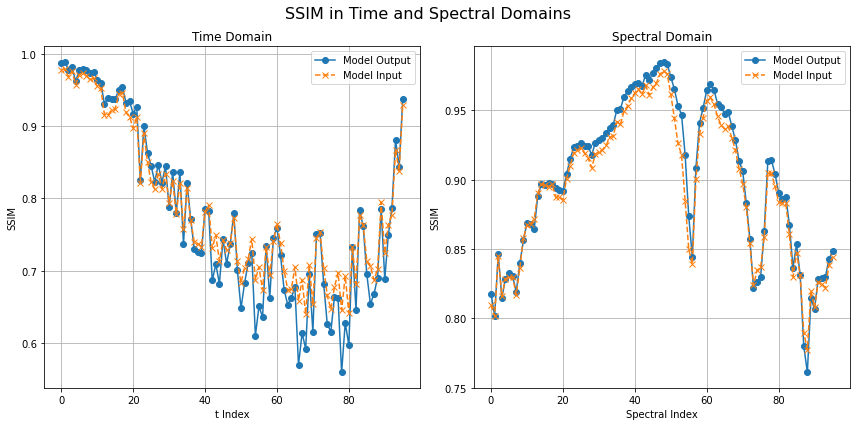

==== Model Output vs. Ground Truth ====
Average SSIM in image domain:    0.7788354929884247
Average SSIM in frequency domain: 0.9001616687211708

==== Model Input vs. Ground Truth ====
Average SSIM in image domain:    0.7888741587682624
Average SSIM in frequency domain: 0.8942607544427439


In [11]:
norm_values_test = np.ones((96,8))

mask = np.load('../data/masks.npy')
mask_5 = mask[:,:,:,5]
mask_5D = mask_5[:,:,:, np.newaxis, np.newaxis]

prediction = prediction*mask_5D
inputs = inputs*mask_5D
ground_truth = ground_truth*mask_5D

plot_general_statistics(prediction, inputs, ground_truth, trancuate_t, norm_values_test,  label = "Model Output", label2 = "Model Input")
plot_general_statistics_PSNR(prediction, inputs, ground_truth, trancuate_t, norm_values_test,  label = "Model Output", label2 = "Model Input")
plot_general_statistics_SSIM(prediction, inputs, ground_truth, trancuate_t, norm_values_test,  label = "Model Output", label2 = "Model Input")

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
../scripts/output_statistics.py:279: RuntimeWarning: invalid value encountered in float_scalars
  return calculate_rmse(pred, gt) / (gt.max() - gt.min())


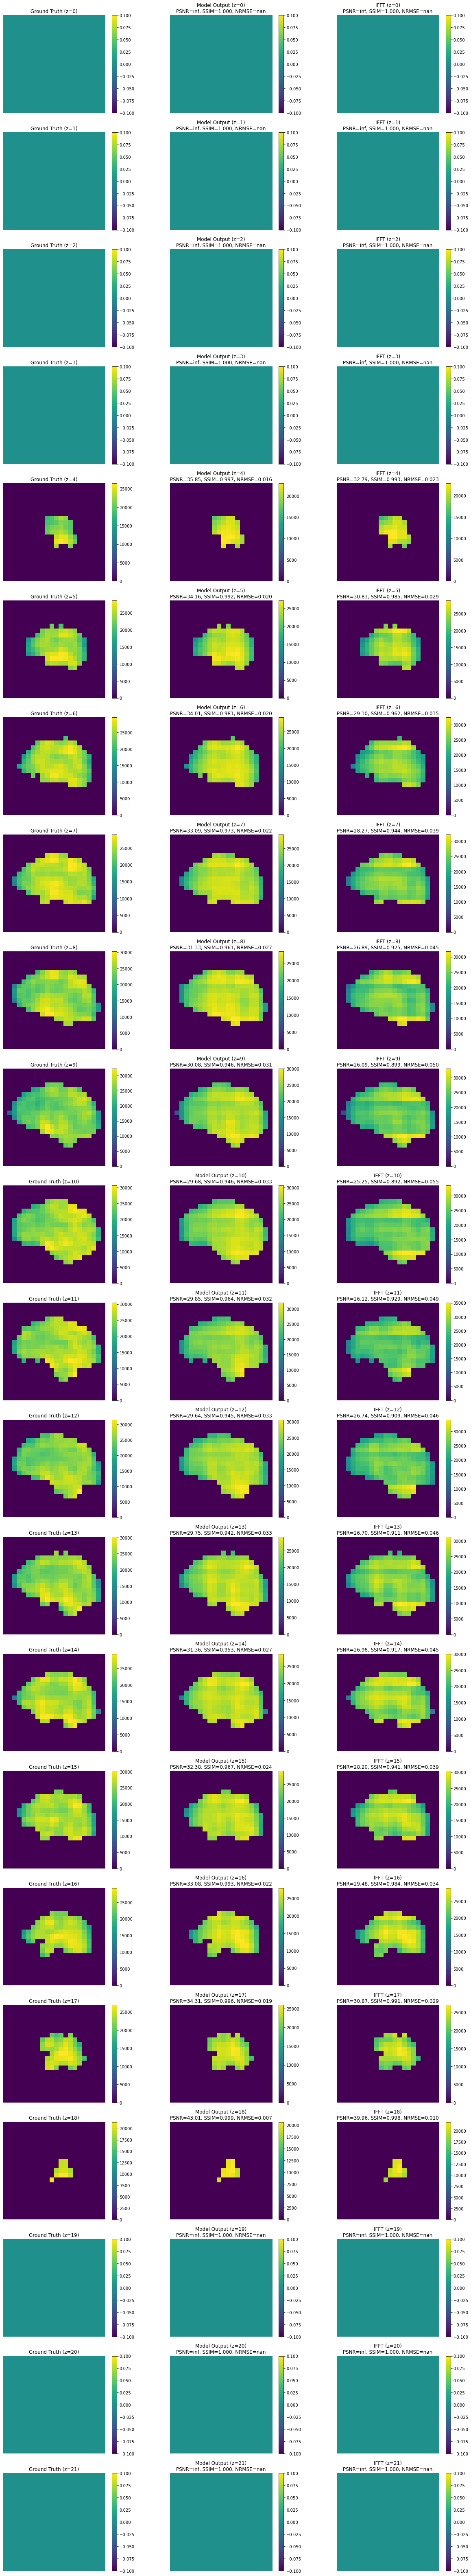

In [12]:
tf = 1 #15 = Water, 17 Glucose, 23 Glx
T = 0

prediction_reshaped = prediction.swapaxes(0, 2)
ground_truth_reshaped = ground_truth.swapaxes(0, 2)
inputs_reshaped = inputs.swapaxes(0, 2)

comparison_Plot_3D_vs_Ifft(prediction_reshaped, ground_truth_reshaped, inputs_reshaped, tf, T, domain="time")

../scripts/output_statistics.py:279: RuntimeWarning: invalid value encountered in double_scalars
  return calculate_rmse(pred, gt) / (gt.max() - gt.min())


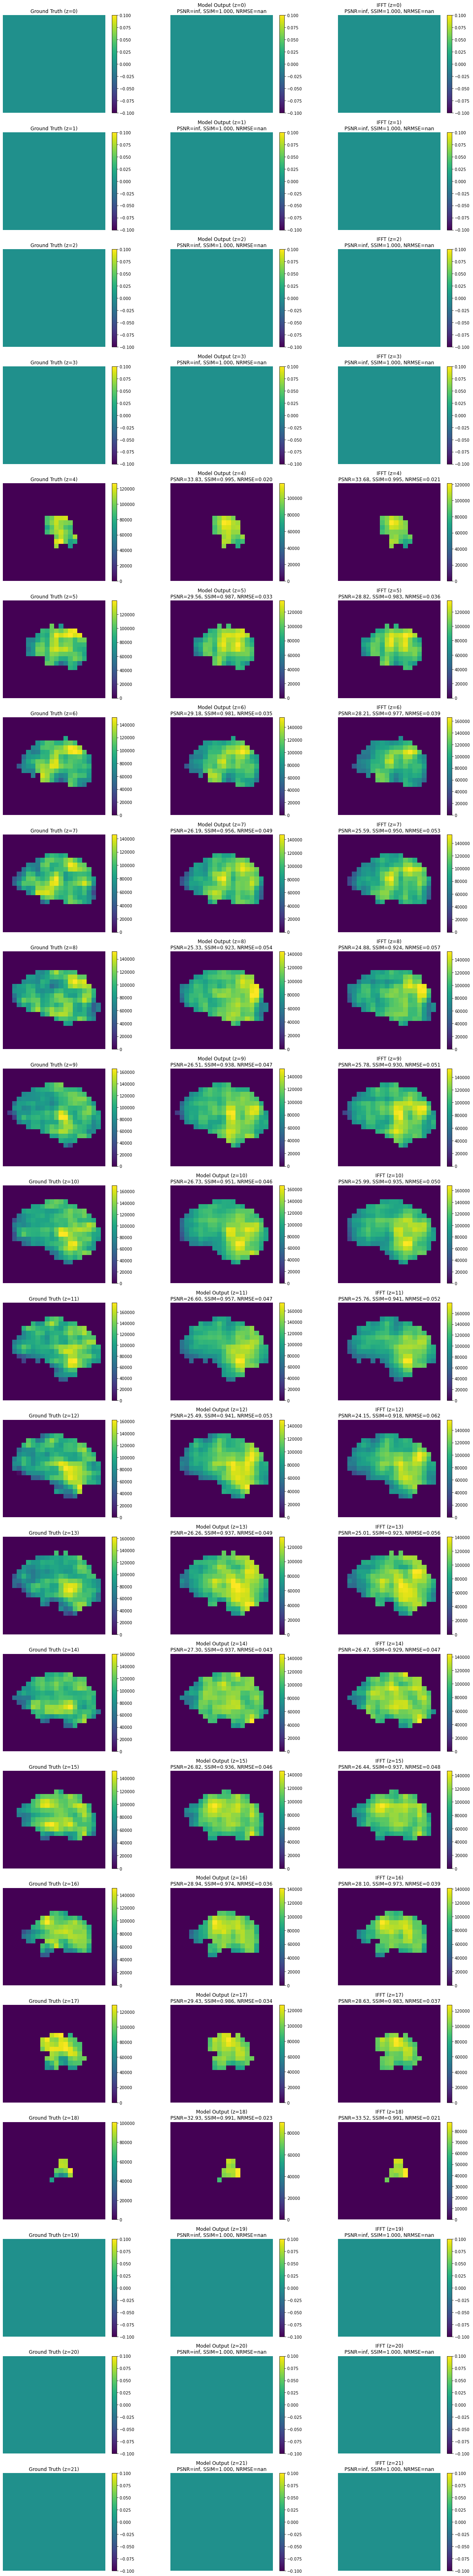

In [13]:
tf = 60 #15 = Water, 17 Glucose, 23 Glx
T = 7

prediction_reshaped = prediction.swapaxes(0, 2)
ground_truth_reshaped = ground_truth.swapaxes(0, 2)
inputs_reshaped = inputs.swapaxes(0, 2)

comparison_Plot_3D_vs_Ifft(prediction_reshaped, ground_truth_reshaped, inputs_reshaped, tf, T, domain="spectral")

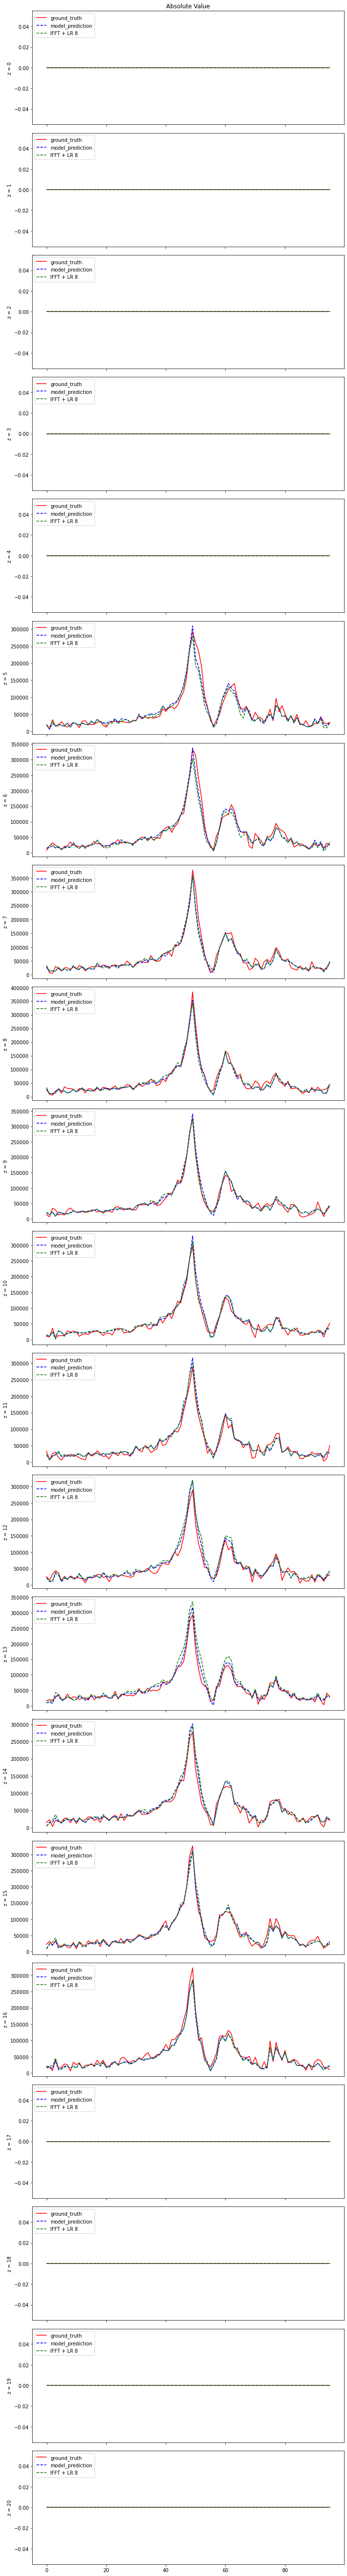

In [23]:
#Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_Regular.npy')
# Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_Regular_Single_Combination.npy')
x = 0 # add that many 0


model_input = np.pad(inputs, pad_width=((0, 0), (0, 0), (0, 0), (0, x), (0, 0)), mode='constant', constant_values=0)
Model_Outputs_Test_Set = np.pad(prediction, pad_width=((0, 0), (0, 0), (0, 0), (0, x), (0, 0)), mode='constant', constant_values=0)
#ground_truth = 
#model_input = low_rank(model_input, 8)*mask_5D
ground_truth_spectral = np.fft.fftshift(np.fft.fft(np.pad(ground_truth, pad_width=((0, 0), (0, 0), (0, 0), (0, x), (0, 0)), mode='constant', constant_values=0), axis=-2), axes=-2)
model_pred_spectral = np.fft.fftshift(np.fft.fft(Model_Outputs_Test_Set, axis=-2), axes=-2)
IFF_LR_8 = np.fft.fftshift(np.fft.fft(model_input, axis=-2), axes=-2)


# Fixed indices for x, y, and T:
x_fixed = 10    # for example
y_fixed = 15    # for example
T_fixed = 7     # for example

num_z = 21  # Number of z slices (rows)

# Create a grid: 21 rows (each z-slice) and 3 columns (abs, real, imaginary)
fig, axes = plt.subplots(nrows=num_z, ncols=1, figsize=(10, num_z * 3.5), sharex=True)

for z in range(num_z):
    # Extract the spectral data at the fixed x, y, T for the current z-slice:
    gt_spec = ground_truth_spectral[x_fixed, y_fixed, z, :, T_fixed]
    mp_spec = model_pred_spectral[x_fixed, y_fixed, z, :, T_fixed]
    iff_spec = IFF_LR_8[x_fixed, y_fixed, z, :, T_fixed]
    
    # --- Column 1: Absolute value ---
    ax_abs = axes[z]
    ax_abs.plot(np.abs(gt_spec), label='ground_truth', color='red')
    ax_abs.plot(np.abs(mp_spec), label='model_prediction', color='blue', linestyle='--')
    ax_abs.plot(np.abs(iff_spec), label='IFFT + LR 8', color='green', linestyle='--')
    ax_abs.set_ylabel(f'z = {z}')
    if z == 0:
        ax_abs.set_title('Absolute Value')
    ax_abs.legend(loc='upper left')
    
#     # --- Column 2: Real part ---
#     ax_real = axes[z, 1]
#     ax_real.plot(np.real(gt_spec), label='ground_truth', color='blue')
#     ax_real.plot(np.real(mp_spec), label='model_prediction', color='orange')
#     ax_real.plot(np.real(iff_spec), label='IFFT + LR 8', color='green')
#     if z == 0:
#         ax_real.set_title('Real Part')
#     ax_real.legend(loc='upper left')
    
#     # --- Column 3: Imaginary part ---
#     ax_imag = axes[z, 2]
#     ax_imag.plot(np.imag(gt_spec), label='ground_truth', color='blue')
#     ax_imag.plot(np.imag(mp_spec), label='model_prediction', color='orange')
#     ax_imag.plot(np.imag(iff_spec), label='IFFT + LR 8', color='green')
#     if z == 0:
#         ax_imag.set_title('Imaginary Part')
#     ax_imag.legend(loc='upper left')

# Set a common x-label (frequency index) for the bottom row subplots
# for ax in axes[-1, :]:
#     ax.set_xlabel('Frequency index (f)')

plt.tight_layout()
plt.show()

In [20]:
model_input.shape

(22, 22, 21, 96, 8)